In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from os.path import join

plt.style.use(["seaborn", "thesis"])

/home/jcartus/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Fetch Dataset 

In [53]:
from SCFInitialGuess.utilities.dataset import extract_triu_batch, AbstractDataset
from sklearn.model_selection import train_test_split
from pyscf.scf import hf

data_path = "../../dataset/EthenT/"
postfix = "EthenT"
dim = 72
N_ELECTRONS = 16
basis = "6-311++g**"
subfolder = "EmbeddedBlocks/"
#data_path = "../../../cc2ai/ethen/"
#postfix = "_ethen_6-31g**"
#dim = 48
#N_ELECTRONS = 16
#basis = "6-31g**"
#data_path = "../../dataset/TSmall_sto3g"
#postfix = "TSmall_sto3g"
#dim = 26
#N_ELECTRONS = 30
#basis = "sto-3g"
#data_path = "../../../butadien/data/"
#postfix = ""
#dim = 26


def split(x, y, ind):
    return x[:ind], y[:ind], x[ind:], y[ind:]

#S, P = np.load(join(data_path, "dataset" + postfix + ".npy"))
S = np.load(join(data_path, "S" + postfix + ".npy"))
P = np.load(join(data_path, "P" + postfix + ".npy"))

#index = np.load(join(data_path, "index" + postfix + ".npy"))


ind = int(0.8 * len(S))

molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))
molecules = (molecules[:ind], molecules[ind:])



h_test = [hf.get_hcore(mol.get_pyscf_molecule()) for mol in molecules[1]]

s_triu_norm, mu, std = AbstractDataset.normalize(S)

s_train, p_train, s_test, p_test = split(S.reshape(-1, dim, dim), P.reshape(-1, dim, dim), ind)

# Utilities 

In [3]:
def fock_from_density(p_batch):
    f = []
    for p, s, h, mol in zip(p_batch, s_test, h_test, molecules[1]):
        f.append(hf.get_fock(None, h1e=h, s1e=s, vhf=hf.get_veff(mol=mol.get_pyscf_molecule(), dm=p), dm=p))
    return np.array(f)

f_test = fock_from_density(p_test)

In [62]:
np.save(data_path + subfolder + "f_conv.npy", f_test)

In [4]:
from pyscf.scf import hf

def density_from_fock(f, s, mol):
    
    mo_energy, mo_coeff = hf.eig(f, s)
    mo_occ = hf.get_occ(mf=hf.SCF(mol), mo_energy=mo_energy, mo_coeff=mo_coeff)
    
    return hf.make_rdm1(mo_coeff, mo_occ)

def density_from_fock_batch(f_batch):
    p = []
    for (s, f, mol) in zip(s_test, f_batch, molecules[1]):
        p.append(density_from_fock(f, s, mol.get_pyscf_molecule()))
    return np.array(p)

In [5]:
from SCFInitialGuess.utilities.analysis import make_results_str, measure_all_quantities
from SCFInitialGuess.utilities.dataset import StaticDataset

dataset = StaticDataset(
    train=(s_train, p_train),
    validation=(None, None),
    test=(s_test, p_test),
    mu=mu,
    std=std
)

In [6]:
f_test.shape

(201, 72, 72)

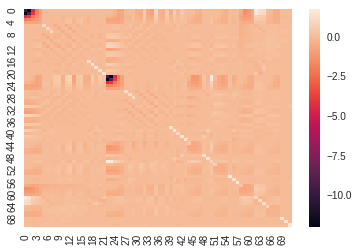

In [7]:
import seaborn as sns

sns.heatmap(f_test[0].reshape(dim, dim))

In [8]:
p_test_test = density_from_fock_batch(f_test)

In [9]:
np.mean(np.abs(p_test.flatten() - p_test_test.flatten()))

3.8222473552948433e-08

In [10]:
from SCFInitialGuess.utilities.analysis import mf_initializer, make_results_str, measure_all_quantities



print(make_results_str(measure_all_quantities(
    p_test_test,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2018-10-15 10:29:18: Iteration calculation: 0
[ ] 2018-10-15 10:29:19: Iteration calculation: 1
[ ] 2018-10-15 10:29:19: Iteration calculation: 2
[ ] 2018-10-15 10:29:20: Iteration calculation: 3
[ ] 2018-10-15 10:29:20: Iteration calculation: 4
[ ] 2018-10-15 10:29:20: Iteration calculation: 5
[ ] 2018-10-15 10:29:21: Iteration calculation: 6
[ ] 2018-10-15 10:29:21: Iteration calculation: 7
[ ] 2018-10-15 10:29:21: Iteration calculation: 8
[ ] 2018-10-15 10:29:22: Iteration calculation: 9
[ ] 2018-10-15 10:29:22: Iteration calculation: 10
[ ] 2018-10-15 10:29:22: Iteration calculation: 11
[ ] 2018-10-15 10:29:23: Iteration calculation: 12
[ ] 2018-10-15 10:29:23: Iteration calculation: 13
[ ] 2018-10-15 10:29:23: Iteration calculation: 14
[ ] 2018-10-15 10:29:24: Iteration calculation: 15
[ ] 2018-10-15 10:29:24: Iteration calculation: 16
[ ] 2018-10-15 10:29:25: Iteration calculation: 17
[ ] 2018-10-15 10:29:25: Iteration calculation: 18
[ ] 2018-10-15 10:29:25: Iteration calcul

[ ] 2018-10-15 10:30:16: Iteration calculation: 160
[ ] 2018-10-15 10:30:16: Iteration calculation: 161
[ ] 2018-10-15 10:30:16: Iteration calculation: 162
[ ] 2018-10-15 10:30:17: Iteration calculation: 163
[ ] 2018-10-15 10:30:17: Iteration calculation: 164
[ ] 2018-10-15 10:30:17: Iteration calculation: 165
[ ] 2018-10-15 10:30:18: Iteration calculation: 166
[ ] 2018-10-15 10:30:18: Iteration calculation: 167
[ ] 2018-10-15 10:30:18: Iteration calculation: 168
[ ] 2018-10-15 10:30:19: Iteration calculation: 169
[ ] 2018-10-15 10:30:19: Iteration calculation: 170
[ ] 2018-10-15 10:30:19: Iteration calculation: 171
[ ] 2018-10-15 10:30:20: Iteration calculation: 172
[ ] 2018-10-15 10:30:20: Iteration calculation: 173
[ ] 2018-10-15 10:30:20: Iteration calculation: 174
[ ] 2018-10-15 10:30:21: Iteration calculation: 175
[ ] 2018-10-15 10:30:21: Iteration calculation: 176
[ ] 2018-10-15 10:30:21: Iteration calculation: 177
[ ] 2018-10-15 10:30:22: Iteration calculation: 178
[ ] 2018-10-

# Pure blocks

i will now set all other elements zero

## Utilities

In [18]:
from SCFInitialGuess.utilities.analysis import mf_initializer_damping as mf_initializer_standard

def mf_initializer(mol):
    mf = mf_initializer_standard(mol)
    mf.max_cycle = 200
    return mf

In [12]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS

mol = molecules[0][0]

mask = np.zeros((dim, dim))

current_dim = 0
for atom in mol.species:
    
    # calculate block range
    index_start = current_dim
    current_dim += N_BASIS[basis][atom] 
    index_end = current_dim
    
    # calculate logical vector
    L = np.arange(dim)
    L = np.logical_and(index_start <= L, L < index_end)
    
    m = np.logical_and.outer(L, L)
    mask = np.logical_or(mask, m)
    
#mask

In [13]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu

def extract_pure(p):
    p_batch = p.copy()
    p_batch[np.logical_not(mask)] = 0
    return p_batch

f_pure = np.array(list(map(extract_pure, f_test))).astype("float64")

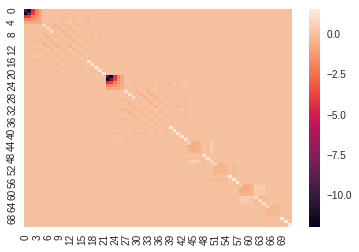

In [14]:
sns.heatmap(f_pure[0])

## Pure Block Analysis 

In [19]:


print(make_results_str(measure_all_quantities(
    density_from_fock_batch(f_pure),
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2018-10-15 11:07:40: Iteration calculation: 0
[ ] 2018-10-15 11:07:44: Iteration calculation: 1
[ ] 2018-10-15 11:07:49: Iteration calculation: 2
[ ] 2018-10-15 11:07:53: Iteration calculation: 3
[ ] 2018-10-15 11:07:57: Iteration calculation: 4
[ ] 2018-10-15 11:08:01: Iteration calculation: 5
[ ] 2018-10-15 11:08:05: Iteration calculation: 6
[ ] 2018-10-15 11:08:10: Iteration calculation: 7
[ ] 2018-10-15 11:08:14: Iteration calculation: 8
[ ] 2018-10-15 11:08:17: Iteration calculation: 9
[ ] 2018-10-15 11:08:21: Iteration calculation: 10
[ ] 2018-10-15 11:08:25: Iteration calculation: 11
[ ] 2018-10-15 11:08:29: Iteration calculation: 12
[ ] 2018-10-15 11:08:33: Iteration calculation: 13
[ ] 2018-10-15 11:08:37: Iteration calculation: 14
[ ] 2018-10-15 11:08:41: Iteration calculation: 15
[ ] 2018-10-15 11:08:46: Iteration calculation: 16
[ ] 2018-10-15 11:08:51: Iteration calculation: 17
[ ] 2018-10-15 11:08:55: Iteration calculation: 18
[ ] 2018-10-15 11:09:00: Iteration calcul

[ ] 2018-10-15 11:19:15: Iteration calculation: 160
[ ] 2018-10-15 11:19:19: Iteration calculation: 161
[ ] 2018-10-15 11:19:24: Iteration calculation: 162
[ ] 2018-10-15 11:19:28: Iteration calculation: 163
[ ] 2018-10-15 11:19:32: Iteration calculation: 164
[ ] 2018-10-15 11:19:36: Iteration calculation: 165
[ ] 2018-10-15 11:19:40: Iteration calculation: 166
[ ] 2018-10-15 11:19:44: Iteration calculation: 167
[ ] 2018-10-15 11:19:49: Iteration calculation: 168
[ ] 2018-10-15 11:19:53: Iteration calculation: 169
[ ] 2018-10-15 11:19:58: Iteration calculation: 170
[ ] 2018-10-15 11:20:02: Iteration calculation: 171
[ ] 2018-10-15 11:20:06: Iteration calculation: 172
[ ] 2018-10-15 11:20:11: Iteration calculation: 173
[ ] 2018-10-15 11:20:15: Iteration calculation: 174
[ ] 2018-10-15 11:20:19: Iteration calculation: 175
[ ] 2018-10-15 11:20:24: Iteration calculation: 176
[ ] 2018-10-15 11:20:28: Iteration calculation: 177
[ ] 2018-10-15 11:20:32: Iteration calculation: 178
[ ] 2018-10-

# Embedding the Blocks In Classical Guesses

In [20]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu

def embedd(x, y):
    p = x.copy()
    p[mask] = (y.copy())[mask]
    return p

def embedd_batch(f_batch):
    f_embedded = []
    for (f_guess, f_conv) in zip(f_batch, f_test):
        f_embedded.append(embedd(f_guess, f_conv))
    return np.array(f_embedded)


## Converged in Converged 

In [21]:
f_test_test_test = embedd_batch(f_test)

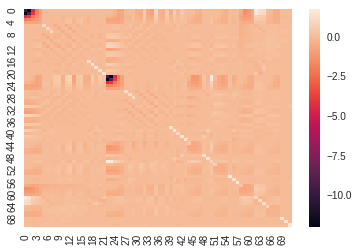

In [22]:
sns.heatmap(f_test_test_test[0])

In [23]:

print(make_results_str(measure_all_quantities(
    density_from_fock_batch(f_test_test_test),
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2018-10-15 11:24:21: Iteration calculation: 0
[ ] 2018-10-15 11:24:21: Iteration calculation: 1
[ ] 2018-10-15 11:24:22: Iteration calculation: 2
[ ] 2018-10-15 11:24:22: Iteration calculation: 3
[ ] 2018-10-15 11:24:22: Iteration calculation: 4
[ ] 2018-10-15 11:24:23: Iteration calculation: 5
[ ] 2018-10-15 11:24:23: Iteration calculation: 6
[ ] 2018-10-15 11:24:23: Iteration calculation: 7
[ ] 2018-10-15 11:24:24: Iteration calculation: 8
[ ] 2018-10-15 11:24:24: Iteration calculation: 9
[ ] 2018-10-15 11:24:24: Iteration calculation: 10
[ ] 2018-10-15 11:24:25: Iteration calculation: 11
[ ] 2018-10-15 11:24:25: Iteration calculation: 12
[ ] 2018-10-15 11:24:25: Iteration calculation: 13
[ ] 2018-10-15 11:24:26: Iteration calculation: 14
[ ] 2018-10-15 11:24:26: Iteration calculation: 15
[ ] 2018-10-15 11:24:26: Iteration calculation: 16
[ ] 2018-10-15 11:24:26: Iteration calculation: 17
[ ] 2018-10-15 11:24:27: Iteration calculation: 18
[ ] 2018-10-15 11:24:27: Iteration calcul

[ ] 2018-10-15 11:25:14: Iteration calculation: 160
[ ] 2018-10-15 11:25:15: Iteration calculation: 161
[ ] 2018-10-15 11:25:15: Iteration calculation: 162
[ ] 2018-10-15 11:25:16: Iteration calculation: 163
[ ] 2018-10-15 11:25:16: Iteration calculation: 164
[ ] 2018-10-15 11:25:16: Iteration calculation: 165
[ ] 2018-10-15 11:25:17: Iteration calculation: 166
[ ] 2018-10-15 11:25:17: Iteration calculation: 167
[ ] 2018-10-15 11:25:17: Iteration calculation: 168
[ ] 2018-10-15 11:25:18: Iteration calculation: 169
[ ] 2018-10-15 11:25:18: Iteration calculation: 170
[ ] 2018-10-15 11:25:18: Iteration calculation: 171
[ ] 2018-10-15 11:25:19: Iteration calculation: 172
[ ] 2018-10-15 11:25:19: Iteration calculation: 173
[ ] 2018-10-15 11:25:19: Iteration calculation: 174
[ ] 2018-10-15 11:25:20: Iteration calculation: 175
[ ] 2018-10-15 11:25:20: Iteration calculation: 176
[ ] 2018-10-15 11:25:20: Iteration calculation: 177
[ ] 2018-10-15 11:25:21: Iteration calculation: 178
[ ] 2018-10-

## Zeros 

In [24]:
f_test_zeros = embedd_batch(np.zeros(f_test.shape))

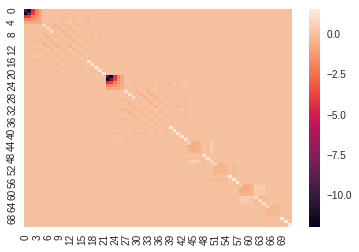

In [25]:
sns.heatmap(f_test_zeros[0])

In [26]:
print(make_results_str(measure_all_quantities(
    density_from_fock_batch(f_test_zeros),
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2018-10-15 11:27:41: Iteration calculation: 0
[ ] 2018-10-15 11:27:47: Iteration calculation: 1
[ ] 2018-10-15 11:27:51: Iteration calculation: 2
[ ] 2018-10-15 11:27:55: Iteration calculation: 3
[ ] 2018-10-15 11:28:00: Iteration calculation: 4
[ ] 2018-10-15 11:28:04: Iteration calculation: 5
[ ] 2018-10-15 11:28:08: Iteration calculation: 6
[ ] 2018-10-15 11:28:13: Iteration calculation: 7
[ ] 2018-10-15 11:28:17: Iteration calculation: 8
[ ] 2018-10-15 11:28:22: Iteration calculation: 9
[ ] 2018-10-15 11:28:26: Iteration calculation: 10
[ ] 2018-10-15 11:28:30: Iteration calculation: 11
[ ] 2018-10-15 11:28:34: Iteration calculation: 12
[ ] 2018-10-15 11:28:39: Iteration calculation: 13
[ ] 2018-10-15 11:28:43: Iteration calculation: 14
[ ] 2018-10-15 11:28:48: Iteration calculation: 15
[ ] 2018-10-15 11:28:52: Iteration calculation: 16
[ ] 2018-10-15 11:28:57: Iteration calculation: 17
[ ] 2018-10-15 11:29:01: Iteration calculation: 18
[ ] 2018-10-15 11:29:05: Iteration calcul

[ ] 2018-10-15 11:39:16: Iteration calculation: 160
[ ] 2018-10-15 11:39:21: Iteration calculation: 161
[ ] 2018-10-15 11:39:25: Iteration calculation: 162
[ ] 2018-10-15 11:39:29: Iteration calculation: 163
[ ] 2018-10-15 11:39:32: Iteration calculation: 164
[ ] 2018-10-15 11:39:36: Iteration calculation: 165
[ ] 2018-10-15 11:39:40: Iteration calculation: 166
[ ] 2018-10-15 11:39:44: Iteration calculation: 167
[ ] 2018-10-15 11:39:49: Iteration calculation: 168
[ ] 2018-10-15 11:39:53: Iteration calculation: 169
[ ] 2018-10-15 11:39:58: Iteration calculation: 170
[ ] 2018-10-15 11:40:02: Iteration calculation: 171
[ ] 2018-10-15 11:40:07: Iteration calculation: 172
[ ] 2018-10-15 11:40:12: Iteration calculation: 173
[ ] 2018-10-15 11:40:16: Iteration calculation: 174
[ ] 2018-10-15 11:40:20: Iteration calculation: 175
[ ] 2018-10-15 11:40:24: Iteration calculation: 176
[ ] 2018-10-15 11:40:29: Iteration calculation: 177
[ ] 2018-10-15 11:40:33: Iteration calculation: 178
[ ] 2018-10-

# GWH

In [27]:
f_gwh = []

k = np.ones((dim, dim)) * 1.75 - \
            np.diag(np.ones(dim)) * 0.75  

for h,s in zip(h_test, s_test):
    h_diag = np.diag(h)   
        
    f_gwh.append(k * np.add.outer(h_diag, h_diag) * s / 2)
    
f_gwh = np.array(f_gwh)

In [63]:
np.save(data_path + subfolder + "f_gwh.npy", f_gwh)

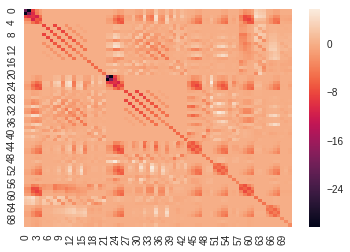

In [28]:
sns.heatmap(f_gwh[0])

In [29]:
print(make_results_str(measure_all_quantities(
    density_from_fock_batch(f_gwh),
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2018-10-15 11:44:27: Iteration calculation: 0
[ ] 2018-10-15 11:44:31: Iteration calculation: 1
[ ] 2018-10-15 11:44:35: Iteration calculation: 2
[ ] 2018-10-15 11:44:40: Iteration calculation: 3
[ ] 2018-10-15 11:44:45: Iteration calculation: 4
[ ] 2018-10-15 11:44:49: Iteration calculation: 5
[ ] 2018-10-15 11:44:53: Iteration calculation: 6
[ ] 2018-10-15 11:44:59: Iteration calculation: 7
[ ] 2018-10-15 11:45:03: Iteration calculation: 8
[ ] 2018-10-15 11:45:07: Iteration calculation: 9
[ ] 2018-10-15 11:45:12: Iteration calculation: 10
[ ] 2018-10-15 11:45:16: Iteration calculation: 11
[ ] 2018-10-15 11:45:20: Iteration calculation: 12
[ ] 2018-10-15 11:45:24: Iteration calculation: 13
[ ] 2018-10-15 11:45:28: Iteration calculation: 14
[ ] 2018-10-15 11:45:32: Iteration calculation: 15
[ ] 2018-10-15 11:45:36: Iteration calculation: 16
[ ] 2018-10-15 11:45:41: Iteration calculation: 17
[ ] 2018-10-15 11:45:45: Iteration calculation: 18
[ ] 2018-10-15 11:45:50: Iteration calcul

[ ] 2018-10-15 11:55:43: Iteration calculation: 160
[ ] 2018-10-15 11:55:48: Iteration calculation: 161
[ ] 2018-10-15 11:55:52: Iteration calculation: 162
[ ] 2018-10-15 11:55:53: Iteration calculation: 163
[ ] 2018-10-15 11:55:59: Iteration calculation: 164
[ ] 2018-10-15 11:56:03: Iteration calculation: 165
[ ] 2018-10-15 11:56:07: Iteration calculation: 166
[ ] 2018-10-15 11:56:12: Iteration calculation: 167
[ ] 2018-10-15 11:56:16: Iteration calculation: 168
[ ] 2018-10-15 11:56:19: Iteration calculation: 169
[ ] 2018-10-15 11:56:23: Iteration calculation: 170
[ ] 2018-10-15 11:56:28: Iteration calculation: 171
[ ] 2018-10-15 11:56:32: Iteration calculation: 172
[ ] 2018-10-15 11:56:36: Iteration calculation: 173
[ ] 2018-10-15 11:56:41: Iteration calculation: 174
[ ] 2018-10-15 11:56:44: Iteration calculation: 175
[ ] 2018-10-15 11:56:50: Iteration calculation: 176
[ ] 2018-10-15 11:56:54: Iteration calculation: 177
[ ] 2018-10-15 11:56:59: Iteration calculation: 178
[ ] 2018-10-

## EmbeddedGWH 

In [30]:
f_embedded_gwh = embedd_batch(f_gwh)

In [64]:
np.save(data_path + subfolder + "f_embedded_gwh.npy", f_embedded_gwh)

### Diff Conv vs GWH 

In [31]:
np.mean(np.abs(f_test.flatten() - f_gwh.flatten()))

0.8039124665156132

### Diff Embedded vs gwh

In [32]:
np.mean(np.abs(f_embedded_gwh.flatten() - f_gwh.flatten()))

0.22515650669336923

### Diff Conv vs Embedded 

In [33]:
np.mean(np.abs(f_embedded_gwh.flatten() - f_test.flatten()))

0.5787559598222435

### Analysing the density

In [34]:
p_embedded_gwh = density_from_fock_batch(f_embedded_gwh)

In [35]:
print(make_results_str(measure_all_quantities(
    p_embedded_gwh,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2018-10-15 12:00:47: Iteration calculation: 0
[ ] 2018-10-15 12:00:49: Iteration calculation: 1
[ ] 2018-10-15 12:00:50: Iteration calculation: 2
[ ] 2018-10-15 12:00:51: Iteration calculation: 3
[ ] 2018-10-15 12:00:52: Iteration calculation: 4
[ ] 2018-10-15 12:00:57: Iteration calculation: 5
[ ] 2018-10-15 12:00:58: Iteration calculation: 6
[ ] 2018-10-15 12:00:59: Iteration calculation: 7
[ ] 2018-10-15 12:00:59: Iteration calculation: 8
[ ] 2018-10-15 12:01:00: Iteration calculation: 9
[ ] 2018-10-15 12:01:01: Iteration calculation: 10
[ ] 2018-10-15 12:01:05: Iteration calculation: 11
[ ] 2018-10-15 12:01:06: Iteration calculation: 12
[ ] 2018-10-15 12:01:10: Iteration calculation: 13
[ ] 2018-10-15 12:01:14: Iteration calculation: 14
[ ] 2018-10-15 12:01:15: Iteration calculation: 15
[ ] 2018-10-15 12:01:16: Iteration calculation: 16
[ ] 2018-10-15 12:01:20: Iteration calculation: 17
[ ] 2018-10-15 12:01:21: Iteration calculation: 18
[ ] 2018-10-15 12:01:26: Iteration calcul

[ ] 2018-10-15 12:05:37: Iteration calculation: 160
[ ] 2018-10-15 12:05:39: Iteration calculation: 161
[ ] 2018-10-15 12:05:39: Iteration calculation: 162
[ ] 2018-10-15 12:05:44: Iteration calculation: 163
[ ] 2018-10-15 12:05:49: Iteration calculation: 164
[ ] 2018-10-15 12:05:53: Iteration calculation: 165
[ ] 2018-10-15 12:05:53: Iteration calculation: 166
[ ] 2018-10-15 12:05:58: Iteration calculation: 167
[ ] 2018-10-15 12:05:59: Iteration calculation: 168
[ ] 2018-10-15 12:06:00: Iteration calculation: 169
[ ] 2018-10-15 12:06:00: Iteration calculation: 170
[ ] 2018-10-15 12:06:01: Iteration calculation: 171
[ ] 2018-10-15 12:06:02: Iteration calculation: 172
[ ] 2018-10-15 12:06:06: Iteration calculation: 173
[ ] 2018-10-15 12:06:06: Iteration calculation: 174
[ ] 2018-10-15 12:06:07: Iteration calculation: 175
[ ] 2018-10-15 12:06:12: Iteration calculation: 176
[ ] 2018-10-15 12:06:16: Iteration calculation: 177
[ ] 2018-10-15 12:06:17: Iteration calculation: 178
[ ] 2018-10-

## SAD

In [36]:
f_sad = fock_from_density(np.array([
    hf.init_guess_by_atom(mol.get_pyscf_molecule()) for mol in molecules[1]
]))

In [65]:
np.save(data_path + subfolder + "f_sad.npy", f_sad)

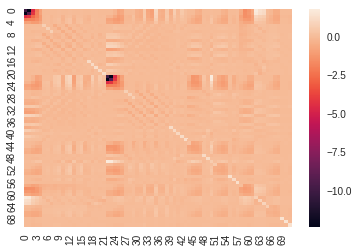

In [37]:
sns.heatmap(f_sad[0])

In [38]:
print(make_results_str(measure_all_quantities(
    density_from_fock_batch(f_sad),
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2018-10-15 12:10:47: Iteration calculation: 0
[ ] 2018-10-15 12:10:48: Iteration calculation: 1
[ ] 2018-10-15 12:10:50: Iteration calculation: 2
[ ] 2018-10-15 12:10:51: Iteration calculation: 3
[ ] 2018-10-15 12:10:52: Iteration calculation: 4
[ ] 2018-10-15 12:10:53: Iteration calculation: 5
[ ] 2018-10-15 12:10:54: Iteration calculation: 6
[ ] 2018-10-15 12:10:54: Iteration calculation: 7
[ ] 2018-10-15 12:10:55: Iteration calculation: 8
[ ] 2018-10-15 12:10:56: Iteration calculation: 9
[ ] 2018-10-15 12:10:57: Iteration calculation: 10
[ ] 2018-10-15 12:10:58: Iteration calculation: 11
[ ] 2018-10-15 12:10:59: Iteration calculation: 12
[ ] 2018-10-15 12:11:00: Iteration calculation: 13
[ ] 2018-10-15 12:11:01: Iteration calculation: 14
[ ] 2018-10-15 12:11:01: Iteration calculation: 15
[ ] 2018-10-15 12:11:02: Iteration calculation: 16
[ ] 2018-10-15 12:11:03: Iteration calculation: 17
[ ] 2018-10-15 12:11:04: Iteration calculation: 18
[ ] 2018-10-15 12:11:05: Iteration calcul

[ ] 2018-10-15 12:13:02: Iteration calculation: 160
[ ] 2018-10-15 12:13:03: Iteration calculation: 161
[ ] 2018-10-15 12:13:04: Iteration calculation: 162
[ ] 2018-10-15 12:13:05: Iteration calculation: 163
[ ] 2018-10-15 12:13:06: Iteration calculation: 164
[ ] 2018-10-15 12:13:07: Iteration calculation: 165
[ ] 2018-10-15 12:13:07: Iteration calculation: 166
[ ] 2018-10-15 12:13:08: Iteration calculation: 167
[ ] 2018-10-15 12:13:09: Iteration calculation: 168
[ ] 2018-10-15 12:13:10: Iteration calculation: 169
[ ] 2018-10-15 12:13:11: Iteration calculation: 170
[ ] 2018-10-15 12:13:11: Iteration calculation: 171
[ ] 2018-10-15 12:13:12: Iteration calculation: 172
[ ] 2018-10-15 12:13:13: Iteration calculation: 173
[ ] 2018-10-15 12:13:14: Iteration calculation: 174
[ ] 2018-10-15 12:13:14: Iteration calculation: 175
[ ] 2018-10-15 12:13:15: Iteration calculation: 176
[ ] 2018-10-15 12:13:16: Iteration calculation: 177
[ ] 2018-10-15 12:13:16: Iteration calculation: 178
[ ] 2018-10-

## Embedded SAD

In [39]:
f_embedded_sad = embedd_batch(f_sad)

In [66]:
np.save(data_path + subfolder + "f_embedded_sad.npy", f_embedded_sad)

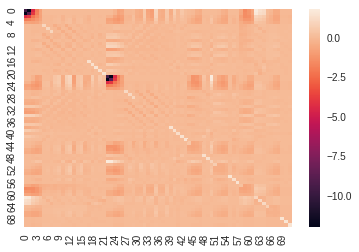

In [40]:
sns.heatmap(f_embedded_sad[0])

In [41]:
p_embedded_sad = density_from_fock_batch(f_embedded_sad)

In [42]:
print(make_results_str(measure_all_quantities(
    p_embedded_sad,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2018-10-15 12:15:49: Iteration calculation: 0
[ ] 2018-10-15 12:15:50: Iteration calculation: 1
[ ] 2018-10-15 12:15:51: Iteration calculation: 2
[ ] 2018-10-15 12:15:52: Iteration calculation: 3
[ ] 2018-10-15 12:15:53: Iteration calculation: 4
[ ] 2018-10-15 12:15:54: Iteration calculation: 5
[ ] 2018-10-15 12:15:55: Iteration calculation: 6
[ ] 2018-10-15 12:15:56: Iteration calculation: 7
[ ] 2018-10-15 12:15:57: Iteration calculation: 8
[ ] 2018-10-15 12:15:58: Iteration calculation: 9
[ ] 2018-10-15 12:15:59: Iteration calculation: 10
[ ] 2018-10-15 12:15:59: Iteration calculation: 11
[ ] 2018-10-15 12:16:00: Iteration calculation: 12
[ ] 2018-10-15 12:16:01: Iteration calculation: 13
[ ] 2018-10-15 12:16:02: Iteration calculation: 14
[ ] 2018-10-15 12:16:03: Iteration calculation: 15
[ ] 2018-10-15 12:16:03: Iteration calculation: 16
[ ] 2018-10-15 12:16:04: Iteration calculation: 17
[ ] 2018-10-15 12:16:05: Iteration calculation: 18
[ ] 2018-10-15 12:16:06: Iteration calcul

[ ] 2018-10-15 12:17:54: Iteration calculation: 160
[ ] 2018-10-15 12:17:55: Iteration calculation: 161
[ ] 2018-10-15 12:17:56: Iteration calculation: 162
[ ] 2018-10-15 12:17:57: Iteration calculation: 163
[ ] 2018-10-15 12:17:58: Iteration calculation: 164
[ ] 2018-10-15 12:17:58: Iteration calculation: 165
[ ] 2018-10-15 12:17:59: Iteration calculation: 166
[ ] 2018-10-15 12:18:00: Iteration calculation: 167
[ ] 2018-10-15 12:18:00: Iteration calculation: 168
[ ] 2018-10-15 12:18:01: Iteration calculation: 169
[ ] 2018-10-15 12:18:02: Iteration calculation: 170
[ ] 2018-10-15 12:18:03: Iteration calculation: 171
[ ] 2018-10-15 12:18:03: Iteration calculation: 172
[ ] 2018-10-15 12:18:04: Iteration calculation: 173
[ ] 2018-10-15 12:18:05: Iteration calculation: 174
[ ] 2018-10-15 12:18:06: Iteration calculation: 175
[ ] 2018-10-15 12:18:06: Iteration calculation: 176
[ ] 2018-10-15 12:18:07: Iteration calculation: 177
[ ] 2018-10-15 12:18:08: Iteration calculation: 178
[ ] 2018-10-

# McWheeny Density

In [43]:
from SCFInitialGuess.utilities.dataset import make_matrix_batch
s_test_batch = make_matrix_batch(S[ind:], dim)

In [44]:
from SCFInitialGuess.nn.post_processing import multi_mc_wheeny

def multi_mc_wheeny_batch(p_batch):
    p_res = []
    for p, s in zip(p_batch, s_test_batch):
        p_res.append(multi_mc_wheeny(p, s, 5))
    return np.asarray(p_res)

### GWH

In [54]:
p_embedded_gwh_mcw5 = multi_mc_wheeny_batch(p_embedded_gwh)

In [46]:
from SCFInitialGuess.utilities.analysis import mf_initializer

print(make_results_str(measure_all_quantities(
    p_embedded_gwh_mcw5,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2018-10-15 12:20:24: Iteration calculation: 0
[ ] 2018-10-15 12:20:25: Iteration calculation: 1
[ ] 2018-10-15 12:20:26: Iteration calculation: 2
[ ] 2018-10-15 12:20:27: Iteration calculation: 3
[ ] 2018-10-15 12:20:29: Iteration calculation: 4
[ ] 2018-10-15 12:20:31: Iteration calculation: 5
[ ] 2018-10-15 12:20:32: Iteration calculation: 6
[ ] 2018-10-15 12:20:33: Iteration calculation: 7
[ ] 2018-10-15 12:20:34: Iteration calculation: 8
[ ] 2018-10-15 12:20:35: Iteration calculation: 9
[ ] 2018-10-15 12:20:36: Iteration calculation: 10
[ ] 2018-10-15 12:20:38: Iteration calculation: 11
[ ] 2018-10-15 12:20:39: Iteration calculation: 12
[ ] 2018-10-15 12:20:42: Iteration calculation: 13
[ ] 2018-10-15 12:20:44: Iteration calculation: 14
[ ] 2018-10-15 12:20:45: Iteration calculation: 15
[ ] 2018-10-15 12:20:46: Iteration calculation: 16
[ ] 2018-10-15 12:20:48: Iteration calculation: 17
[ ] 2018-10-15 12:20:50: Iteration calculation: 18
[ ] 2018-10-15 12:20:52: Iteration calcul

[ ] 2018-10-15 12:24:07: Iteration calculation: 160
[ ] 2018-10-15 12:24:08: Iteration calculation: 161
[ ] 2018-10-15 12:24:09: Iteration calculation: 162
[ ] 2018-10-15 12:24:12: Iteration calculation: 163
[ ] 2018-10-15 12:24:14: Iteration calculation: 164
[ ] 2018-10-15 12:24:16: Iteration calculation: 165
[ ] 2018-10-15 12:24:17: Iteration calculation: 166
[ ] 2018-10-15 12:24:19: Iteration calculation: 167
[ ] 2018-10-15 12:24:20: Iteration calculation: 168
[ ] 2018-10-15 12:24:22: Iteration calculation: 169
[ ] 2018-10-15 12:24:22: Iteration calculation: 170
[ ] 2018-10-15 12:24:23: Iteration calculation: 171
[ ] 2018-10-15 12:24:24: Iteration calculation: 172
[ ] 2018-10-15 12:24:25: Iteration calculation: 173
[ ] 2018-10-15 12:24:26: Iteration calculation: 174
[ ] 2018-10-15 12:24:27: Iteration calculation: 175
[ ] 2018-10-15 12:24:29: Iteration calculation: 176
[ ] 2018-10-15 12:24:31: Iteration calculation: 177
[ ] 2018-10-15 12:24:32: Iteration calculation: 178
[ ] 2018-10-

### SAP 

In [47]:
p_embedded_sap_mcw5 = multi_mc_wheeny_batch(p_embedded_sad)

In [48]:
from SCFInitialGuess.utilities.analysis import mf_initializer

print(make_results_str(measure_all_quantities(
    p_embedded_sap_mcw5,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2018-10-15 12:27:01: Iteration calculation: 0
[ ] 2018-10-15 12:27:01: Iteration calculation: 1
[ ] 2018-10-15 12:27:02: Iteration calculation: 2
[ ] 2018-10-15 12:27:03: Iteration calculation: 3
[ ] 2018-10-15 12:27:04: Iteration calculation: 4
[ ] 2018-10-15 12:27:05: Iteration calculation: 5
[ ] 2018-10-15 12:27:06: Iteration calculation: 6
[ ] 2018-10-15 12:27:07: Iteration calculation: 7
[ ] 2018-10-15 12:27:07: Iteration calculation: 8
[ ] 2018-10-15 12:27:08: Iteration calculation: 9
[ ] 2018-10-15 12:27:09: Iteration calculation: 10
[ ] 2018-10-15 12:27:09: Iteration calculation: 11
[ ] 2018-10-15 12:27:10: Iteration calculation: 12
[ ] 2018-10-15 12:27:11: Iteration calculation: 13
[ ] 2018-10-15 12:27:11: Iteration calculation: 14
[ ] 2018-10-15 12:27:12: Iteration calculation: 15
[ ] 2018-10-15 12:27:13: Iteration calculation: 16
[ ] 2018-10-15 12:27:14: Iteration calculation: 17
[ ] 2018-10-15 12:27:15: Iteration calculation: 18
[ ] 2018-10-15 12:27:15: Iteration calcul

[ ] 2018-10-15 12:29:18: Iteration calculation: 160
[ ] 2018-10-15 12:29:19: Iteration calculation: 161
[ ] 2018-10-15 12:29:19: Iteration calculation: 162
[ ] 2018-10-15 12:29:20: Iteration calculation: 163
[ ] 2018-10-15 12:29:22: Iteration calculation: 164
[ ] 2018-10-15 12:29:23: Iteration calculation: 165
[ ] 2018-10-15 12:29:23: Iteration calculation: 166
[ ] 2018-10-15 12:29:24: Iteration calculation: 167
[ ] 2018-10-15 12:29:25: Iteration calculation: 168
[ ] 2018-10-15 12:29:26: Iteration calculation: 169
[ ] 2018-10-15 12:29:27: Iteration calculation: 170
[ ] 2018-10-15 12:29:28: Iteration calculation: 171
[ ] 2018-10-15 12:29:29: Iteration calculation: 172
[ ] 2018-10-15 12:29:30: Iteration calculation: 173
[ ] 2018-10-15 12:29:31: Iteration calculation: 174
[ ] 2018-10-15 12:29:31: Iteration calculation: 175
[ ] 2018-10-15 12:29:32: Iteration calculation: 176
[ ] 2018-10-15 12:29:33: Iteration calculation: 177
[ ] 2018-10-15 12:29:33: Iteration calculation: 178
[ ] 2018-10-

# McWheeny Fock 

In [49]:
from SCFInitialGuess.nn.post_processing import multi_mc_wheeny

def multi_mc_wheeny_batch_fock(p_batch):
    p_res = []
    for p, s in zip(p_batch, s_test_batch):
        p_res.append(multi_mc_wheeny(p, s, 1))
    return np.asarray(p_res)

## GWH 

In [50]:
f_gwh_mcw5 = multi_mc_wheeny_batch_fock(f_gwh)

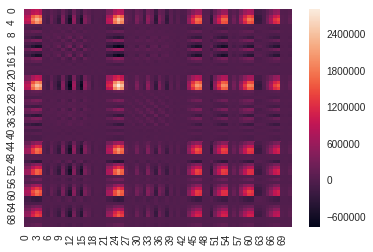

In [51]:
sns.heatmap(f_gwh_mcw5[0])